# MXNET

---

## Import libraries

In [1]:
import time
import pickle
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import mxnet as mx
from mxnet import gluon, autograd, nd
from mxnet.gluon import nn
from mxnet.gluon.data import DataLoader, ArrayDataset
from mxnet.gluon.loss import SoftmaxCrossEntropyLoss

## Load data

The first step is to load the preprocessed data.

In [2]:
with open('../data/preprocessed_data.pkl', 'rb') as f:
    X_train, y_train, X_val, y_val, X_test, y_test = pickle.load(f)

Because `MXNet Gluon` support label in type of integer, we convert them to numerical values.

In [11]:
y_train = np.argmax(y_train, axis=1)
y_val = np.argmax(y_val, axis=1)
y_test = np.argmax(y_test, axis=1)

## Design model

We will construct the model with the following architecture:
- Hidden Layers: Two layers with 256 and 128 neurons, respectively.
- Activation Function: ReLU (Rectified Linear Unit).
- Optimizer: Adam.
- Batch Size: 128.
- Learning Rate: Initial value of 0.001, decreasing by 0.1% every 10 epochs.
- Maximum Iterations: 200.
- Early Stopping: Stop training if the loss does not improve within 10 epochs.

In [12]:
# Hyperparameters
initial_lr = 0.001             # Initial learning rate
patience = 10                  # Early stopping patience
min_delta = 0.001              # Minimum improvement to reset patience
best_val_loss = float('inf')   # Best validation loss
epochs_no_improve = 0          # Count epochs with no improvement
max_epoch = 200                # Maximum epochs
decay_epochs = 10              # Decay learning rate after X epochs
batch_size = 128               # Batch size

# Build the model
class MLPClassifier(nn.Block):
    def __init__(self):
        super(MLPClassifier, self).__init__()
        self.net = nn.Sequential()
        self.net.add(
            nn.Dense(256, activation='relu'),
            nn.Dense(128, activation='relu'),
            nn.Dense(10)  
        )
    def forward(self, x):
        return self.net(x)
    
# Check if GPU is available
device = mx.gpu() if mx.context.num_gpus() > 0 else mx.cpu()
print(f"Using device: {device}")

# Initialize the model
model = MLPClassifier()
model.initialize(mx.init.Xavier(), ctx=device)

Using device: cpu(0)


## Selecting Loss Function and Optimizer

We will utilize cross-entropy loss and the Adam optimizer.

In [13]:
# Loss function và optimizer
criterion = SoftmaxCrossEntropyLoss()
trainer = gluon.Trainer(model.collect_params(), 'adam', {'learning_rate': initial_lr})

## Model Training

In [14]:
# DataLoader
train_dataset = ArrayDataset(nd.array(X_train), nd.array(y_train))
val_dataset = ArrayDataset(nd.array(X_val), nd.array(y_val))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Training variables
train_losses = []
val_losses = []
val_accuracies = []

# Mark the start time
start_time = time.time()

# Training loop
for epoch in range(max_epoch):
    # Train the model
    train_loss = 0.0

    for data, label in train_loader:
        data = data.as_in_context(device)
        label = label.as_in_context(device)

        with autograd.record():
            output = model(data)
            loss = criterion(output, label)
        loss.backward()
        trainer.step(batch_size)

        train_loss += loss.mean().asscalar()

    # Calculate average losses
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validate the model
    val_loss = 0.0
    correct = 0
    total = 0

    for data, label in val_loader:
        data = data.as_in_context(device)
        label = label.as_in_context(device)

        output = model(data)
        loss = criterion(output, label)
        val_loss += loss.mean().asscalar()

        predictions = nd.argmax(output, axis=1)
        correct += (predictions == label).sum().asscalar()
        total += label.size

    # Calculate average losses and accuracies
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracy = (correct / total) * 100
    val_accuracies.append(val_accuracy)

    # Print the progress
    print(f"Epoch {epoch + 1}/{max_epoch}, Train Loss: {avg_train_loss:.4f}, "
        f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # Early Stopping
    if avg_val_loss < best_val_loss - min_delta:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        model.save_parameters("best_model.params")
        print("Validation loss improved. Saving model...")
    else:
        epochs_no_improve += 1
        print(f"No improvement for {epochs_no_improve} epochs.")

    # Check early stopping condition
    if epochs_no_improve >= patience:
        print("Early stopping triggered!")
        break

    # Learning rate decay
    if (epoch + 1) % decay_epochs == 0:
        new_lr = trainer.learning_rate * 0.1
        trainer.set_learning_rate(new_lr)

# Mark the end time
end_time = time.time()

Epoch 1/200, Train Loss: 1.9033, Validation Loss: 1.8121, Validation Accuracy: 35.91%
Validation loss improved. Saving model...
Epoch 2/200, Train Loss: 1.7235, Validation Loss: 1.7303, Validation Accuracy: 38.39%
Validation loss improved. Saving model...
Epoch 3/200, Train Loss: 1.6553, Validation Loss: 1.6674, Validation Accuracy: 40.78%
Validation loss improved. Saving model...
Epoch 4/200, Train Loss: 1.5989, Validation Loss: 1.6424, Validation Accuracy: 41.95%
Validation loss improved. Saving model...
Epoch 5/200, Train Loss: 1.5420, Validation Loss: 1.6107, Validation Accuracy: 42.68%
Validation loss improved. Saving model...
Epoch 6/200, Train Loss: 1.5161, Validation Loss: 1.5583, Validation Accuracy: 45.53%
Validation loss improved. Saving model...
Epoch 7/200, Train Loss: 1.4920, Validation Loss: 1.5616, Validation Accuracy: 44.62%
No improvement for 1 epochs.
Epoch 8/200, Train Loss: 1.4576, Validation Loss: 1.5323, Validation Accuracy: 45.99%
Validation loss improved. Savin

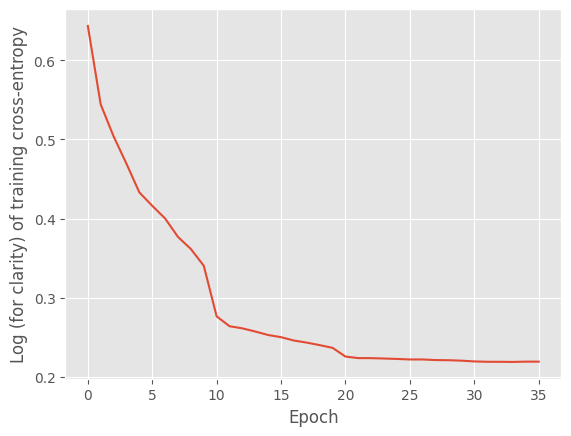

In [15]:
plt.plot(np.log(train_losses))
plt.xlabel('Epoch')
plt.ylabel('Log (for clarity) of training cross-entropy')
plt.show()

In [16]:
# Calculate the training time
training_time = end_time - start_time
print(f"Training time: {training_time:.2f} seconds")

Training time: 147.69 seconds


## Model Evaluation

Accuracy: 0.5108
Precision: 0.5057
Recall: 0.5108
F1 Score: 0.5070


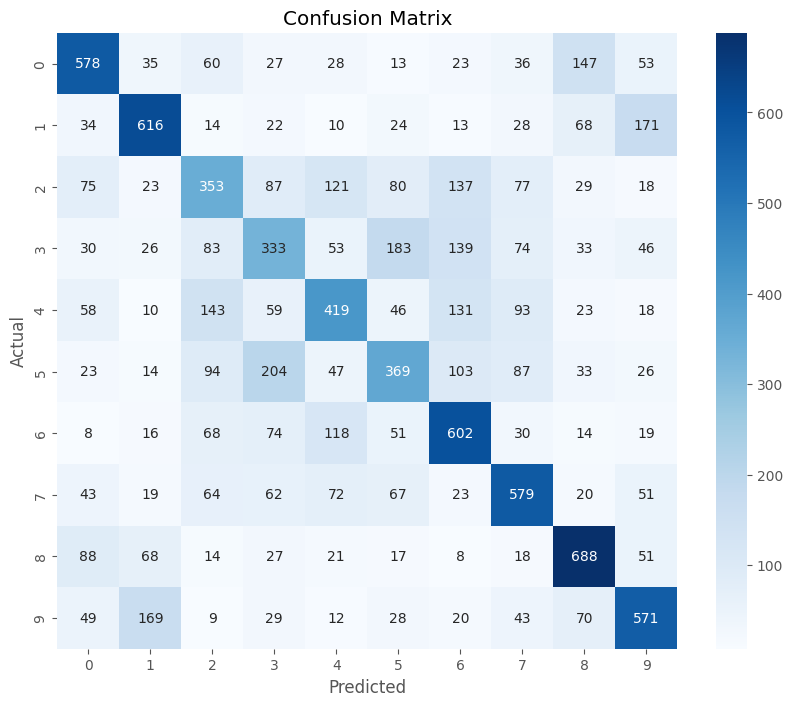

In [17]:
# Convert the test data to NDArray
X_test = nd.array(X_test).as_in_context(device)
y_test = nd.array(y_test).as_in_context(device)

# Predict the test data
output = model(X_test)
predictions = nd.argmax(output, axis=1)

# Convert the predictions and true labels to NumPy arrays
predictions = predictions.asnumpy()
y_test = y_test.asnumpy()

# Calculate the evaluation metrics
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='weighted')
recall = recall_score(y_test, predictions, average='weighted')
f1 = f1_score(y_test, predictions, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Futher Usage

In [19]:
# Save the model
model.save_parameters('mxnet_model.params')

# Load the model
model = MLPClassifier()
model.initialize(mx.init.Xavier(), ctx=device)
model.load_parameters('mxnet_model.params', ctx=device)

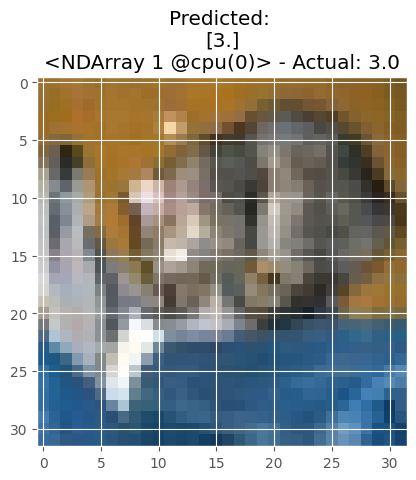

In [20]:
single_image = nd.array(X_test[0]).as_in_context(device)  # first image in test
output = model(single_image.expand_dims(0)) 
predictions = nd.argmax(output, axis=1)
plt.imshow(single_image.reshape(32, 32, 3).asnumpy())  
plt.title(f'Predicted: {predictions[0]} - Actual: {y_test[0]}')
plt.show()